# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 15: Heat transport

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

In [1]:
#  Ensure compatibility with Python 2 and 3
from __future__ import print_function, division

## Contents

1. [Spatial patterns of insolation and surface temperature](#section1)
2. [Calculating Radiative-Convective Equilibrium as a function of latitude](#section2)
3. [Observed and modeled TOA radiation budget](#section3)
4. [The energy budget for a zonal band](#section4)
5. [Observed and modeled poleward heat transport](#section5)
6. [Energy budgets for the atmosphere and ocean](#section6)
7. [Calculating the partitioning of poleward energy transport into different components](#section7)
8. [Mechanisms of heat transport](#section8)


____________
<a id='section1'></a>

## 1. Spatial patterns of insolation and surface temperature
____________

Let's take a look at seasonal and spatial pattern of insolation and compare this to the zonal average surface temperatures.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import sin, cos, deg2rad, log, exp
import climlab
from climlab import constants as const
#  Disable interactive plotting (use explicit display calls to show figures)
plt.ioff()

In [3]:
#  Calculate daily average insolation as function of latitude and time of year
lat = np.linspace( -90., 90., 500 )
days = np.linspace(0, const.days_per_year, 365 )
Q = climlab.solar.insolation.daily_insolation( lat, days )

In [4]:
## The NOAA ESRL server is shutdown! January 2019
##  daily surface temperature from  NCEP reanalysis
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
#ncep_temp = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/'
skt_path = 'surface_gauss/skt'
ncep_temp = xr.open_dataset(url+skt_path)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')

In [5]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
CS = ax1.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax1.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax1.set_title('Daily average insolation', fontsize=18 )
ax1.contourf ( days, lat, Q, levels=[-100., 0.], colors='k' )

ax2 = fig.add_subplot(122)
CS = ax2.contour( (ncep_temp.time - ncep_temp.time[0])/const.hours_per_day, ncep_temp.lat, 
                 ncep_temp_zon.T, levels=np.arange(210., 310., 10. ) )
ax2.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax2.set_title('Observed zonal average surface temperature', fontsize=18 )

for ax in [ax1,ax2]:
    ax.set_xlabel('Days since January 1', fontsize=16 )
    ax.set_ylabel('Latitude', fontsize=16 )
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.grid()

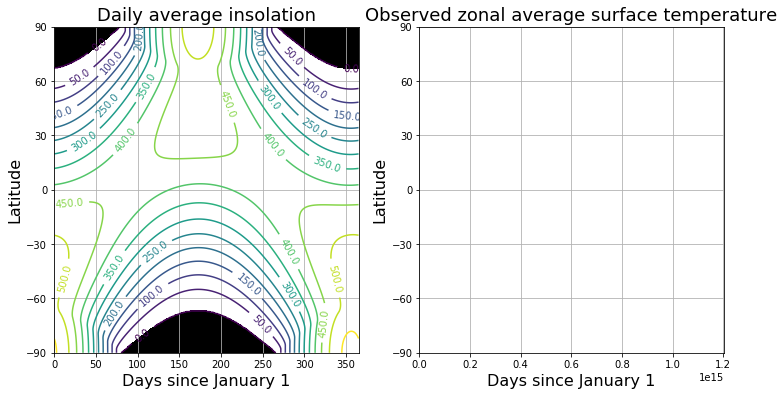

In [6]:
fig

This figure reveals something fairly obvious, but still worth thinking about:

**Warm temperatures are correlated with high insolation**. It's warm where the sun shines.

More specifically, we can see a few interesting details here:

- The seasonal cycle is weakest in the tropics and strongest in the high latitudes.
- The warmest temperatures occur slighly NORTH of the equator
- The highest insolation occurs at the poles at summer solstice.

The local surface temperature does not correlate perfectly with local insolation for two reasons:

- the climate system has heat capacity, which buffers some of the seasonal variations
- the climate system moves energy around in space!

____________
<a id='section2'></a>

## 2. Calculating Radiative-Convective Equilibrium as a function of latitude
____________

As a first step to understanding the effects of **heat transport by fluid motions** in the atmosphere and ocean, we can calculate **what the surface temperature would be without any motion**.

Let's calculate a **radiative-convective equilibrium** state for every latitude band.

### Putting realistic insolation into an RCM

This code demonstrates how to create a model with both latitude and vertical dimensions.

In [7]:
# A two-dimensional domain
state = climlab.column_state(num_lev=30, num_lat=60, water_depth=10.)
#  The top-level model
model = climlab.TimeDependentProcess(state=state)
#  Specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Hard convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(domains=model.Ts.domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(state=state, 
                              specific_humidity=h2o.q, 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen)
model.add_subprocess('Radiation', rad)
model.add_subprocess('Insolation', sun)
model.add_subprocess('WaterVapor', h2o)
model.add_subprocess('Convection', conv)

print( model)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (60, 1) 
  Tatm: (60, 30) 
The subprocess tree: 
Untitled: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   WaterVapor: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [8]:
model.compute_diagnostics()

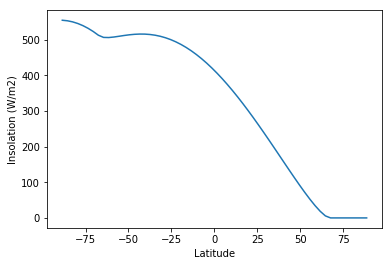

In [9]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.insolation)
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');
fig

This new insolation process uses the same code we've already been working with to compute realistic distributions of insolation. Here we are using
```
climlab.radiation.DailyInsolation
```
but there is also

```
climlab.radiation.AnnualMeanInsolation
```
for models in which you prefer to suppress the seasonal cycle and prescribe a time-invariant insolation.

The following code will just integrate the model forward in four steps in order to get snapshots of insolation at the solstices and equinoxes.

In [10]:
#  model is initialized on Jan. 1

#  integrate forward just under 1/4 year... should get about to the NH spring equinox
model.integrate_days(31+28+22)
Q_spring = model.insolation.copy()
#  Then forward to NH summer solstice
model.integrate_days(31+30+31)
Q_summer = model.insolation.copy()
#  and on to autumnal equinox
model.integrate_days(30+31+33)
Q_fall = model.insolation.copy()
#  and finally to NH winter solstice
model.integrate_days(30+31+30)
Q_winter = model.insolation.copy()

Integrating for 81 steps, 81.0 days, or 0.22177064972229385 years.
Total elapsed time is 0.22177064972229385 years.
Integrating for 91 steps, 91.99999999999999 days, or 0.2518876515364325 years.
Total elapsed time is 0.4709203920028956 years.
Integrating for 94 steps, 94.00000000000001 days, or 0.2573634700480941 years.
Total elapsed time is 0.7282838620509897 years.
Integrating for 91 steps, 91.0 days, or 0.24914974228060174 years.
Total elapsed time is 0.9774336043315914 years.


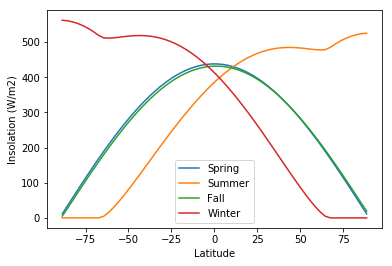

In [11]:
fig, ax = plt.subplots()
ax.plot(model.lat, Q_spring, label='Spring')
ax.plot(model.lat, Q_summer, label='Summer')
ax.plot(model.lat, Q_fall, label='Fall')
ax.plot(model.lat, Q_winter, label='Winter')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');
fig

This just serves to demonstrate that the `DailyInsolation` process is doing something sensible.

Note that we could also pass different orbital parameters to this subprocess. They default to present-day values, which is what we are using here.

### Find the steady seasonal cycle of temperature in radiative-convective equilibrium

In [12]:
model.integrate_years(4.)

Integrating for 1460 steps, 1460.9688 days, or 4.0 years.
Total elapsed time is 4.974781117844542 years.


In [13]:
model.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 5.97411799622278 years.


All climlab `Process` objects have an attribute called `timeave`. 

This is a dictionary of time-averaged diagnostics, which are automatically calculated during the most recent call to `integrate_years()` or `integrate_days()`.

In [14]:
model.timeave.keys()

dict_keys(['Ts', 'Tatm', 'OLR', 'OLRclr', 'OLRcld', 'TdotLW', 'TdotLW_clr', 'LW_sfc', 'LW_sfc_clr', 'LW_flux_up', 'LW_flux_down', 'LW_flux_net', 'LW_flux_up_clr', 'LW_flux_down_clr', 'LW_flux_net_clr', 'ASR', 'ASRclr', 'ASRcld', 'TdotSW', 'TdotSW_clr', 'SW_sfc', 'SW_sfc_clr', 'SW_flux_up', 'SW_flux_down', 'SW_flux_net', 'SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr', 'insolation', 'coszen', 'q'])

Here we use the `timeave['insolation']` to plot the annual mean insolation. 

(We know it is the *annual* average because the last call to `model.integrate_years` was for exactly 1 year)

In [15]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['insolation'])
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)')

###  Compare annual average temperature in RCE to the zonal-, annual mean observations.

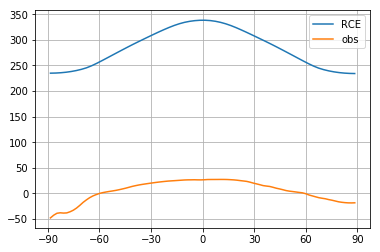

In [16]:
# Plot annual mean surface temperature in the model,
#   compare to observed annual mean surface temperatures
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['Ts'], label='RCE')
ax.plot(ncep_temp_zon.lat, ncep_temp_zon.mean(dim='time'), label='obs')
ax.set_xticks(range(-90,100,30))
ax.grid(); ax.legend();
fig

Our modeled RCE state is **far too warm in the tropics**, and **too cold in the mid- to high latitudes.**

###  Vertical structure of temperature: comparing RCE to observations

In [17]:
#  Observed air temperature from NCEP reanalysis
## The NOAA ESRL server is shutdown! January 2019
#ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", decode_times=False)
air = xr.open_dataset(url+'pressure/air')
ncep_air = air.rename({'lev':'level'})
level_ncep_air = ncep_air.level
lat_ncep_air = ncep_air.lat
Tzon = ncep_air.air.mean(dim=('time','lon'))

In [18]:
#  Compare temperature profiles in RCE and observations
contours = np.arange(180., 350., 15.)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
cax1 = ax1.contourf(lat_ncep_air, level_ncep_air, Tzon+const.tempCtoK, levels=contours)
fig.colorbar(cax1)
ax1.set_title('Observered temperature (K)')

ax2 = fig.add_subplot(1,2,2)
field = model.timeave['Tatm'].transpose()
cax2 = ax2.contourf(model.lat, model.lev, field, levels=contours)
fig.colorbar(cax2)
ax2.set_title('RCE temperature (K)')

for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])

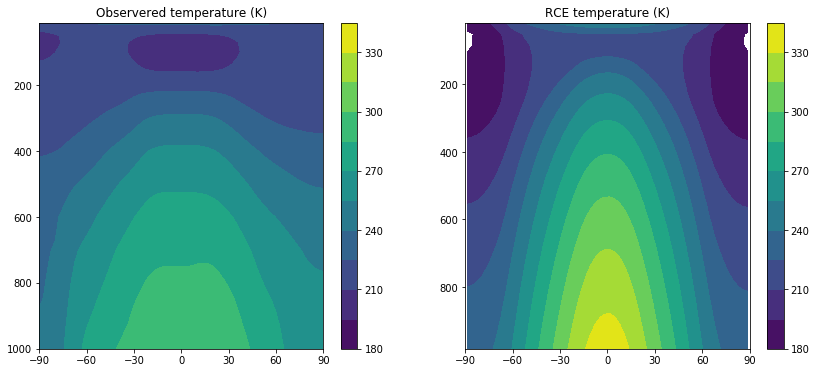

In [19]:
fig

Again, this plot reveals temperatures that are too warm in the tropics, too cold at the poles throughout the troposphere.

Note however that the **vertical temperature gradients** are largely dictated by the convective adjustment in our model. We have parameterized this gradient, and so we can change it by changing our parameter for the adjustment.

We have (as yet) no parameterization for the **horizontal** redistribution of energy in the climate system.

###  TOA energy budget in RCE equilibrium

Because there is no horizontal energy transport in this model, the TOA radiation budget should be closed (net flux is zero) at all latitudes.

Let's check this by plotting time-averaged shortwave and longwave radiation:

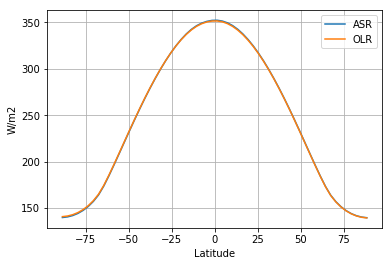

In [20]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['ASR'], label='ASR')
ax.plot(model.lat, model.timeave['OLR'], label='OLR')
ax.set_xlabel('Latitude')
ax.set_ylabel('W/m2')
ax.legend(); ax.grid()
fig

Indeed, the budget is (very nearly) closed everywhere. Each latitude is in energy balance, independent of every other column.

____________
<a id='section3'></a>

## 3. Observed and modeled TOA radiation budget
____________


We are going to look at the (time average) TOA budget as a function of latitude to see how it differs from the RCE state we just plotted.

Ideally we would look at actual satellite observations of SW and LW fluxes. Instead, here we will use the NCEP Reanalysis for convenience. 

But bear in mind that the radiative fluxes in the reanalysis are a model-generated product, they are not really observations.

### TOA budget from NCEP Reanalysis

In [21]:
# Get TOA radiative flux data from NCEP reanalysis
# downwelling SW
#dswrf = xr.open_dataset(ncep_url + '/other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
dswrf = xr.open_dataset(url + 'other_gauss/dswrf')
#  upwelling SW
#uswrf = xr.open_dataset(ncep_url + '/other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
uswrf = xr.open_dataset(url + 'other_gauss/uswrf')
#  upwelling LW
#ulwrf = xr.open_dataset(ncep_url + '/other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
ulwrf = xr.open_dataset(url + 'other_gauss/ulwrf')

In [22]:
ASR = dswrf.dswrf - uswrf.uswrf
OLR = ulwrf.ulwrf

In [23]:
ASRzon = ASR.mean(dim=('time','lon'))
OLRzon = OLR.mean(dim=('time','lon'))

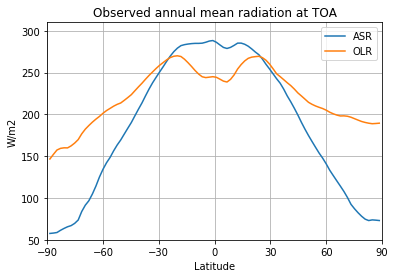

In [24]:
ticks = [-90, -60, -30, 0, 30, 60, 90]
fig, ax = plt.subplots()
ax.plot(ASRzon.lat, ASRzon, label='ASR')
ax.plot(OLRzon.lat, OLRzon, label='OLR')
ax.set_ylabel('W/m2')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.set_title('Observed annual mean radiation at TOA')
ax.legend(); ax.grid();
fig

We find that ASR does NOT balance OLR in most locations. 

Across the tropics the absorbed solar radiation exceeds the longwave emission to space.  The tropics have a **net gain of energy by radiation**.

The opposite is true in mid- to high latitudes: **the Earth is losing energy by net radiation to space** at these latitudes.

### TOA budget from the control CESM simulation

In [25]:
#  same thing from CESM control simulation
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_control/som_control.cam.h0.clim.nc' + endstr, decode_times=False)
atm_2xCO2 = xr.open_dataset( datapath + 'som_2xCO2/som_2xCO2.cam.h0.clim.nc' + endstr, decode_times=False)

In [26]:
lat_cesm = atm_control.lat
ASR_cesm = atm_control.FSNT
OLR_cesm = atm_control.FLNT

In [27]:
ASR_cesm_zon = ASR_cesm.mean(dim=('lon','time'))
OLR_cesm_zon = OLR_cesm.mean(dim=('lon','time'))

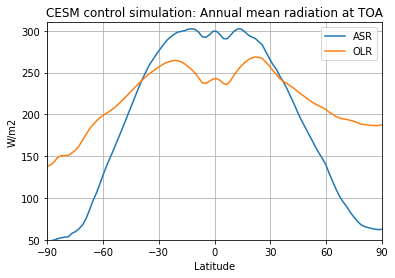

In [28]:
fig, ax = plt.subplots()
ax.plot(lat_cesm, ASR_cesm_zon, label='ASR')
ax.plot(lat_cesm, OLR_cesm_zon, label='OLR')
ax.set_ylabel('W/m2')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.set_title('CESM control simulation: Annual mean radiation at TOA')
ax.legend(); ax.grid();
fig

Essentially the same story as the reanalysis data: there is a **surplus of energy across the tropics** and a net **energy deficit in mid- to high latitudes**.

There are two locations where ASR = OLR, near about 35º in both hemispheres. 

____________
<a id='section4'></a>

## 4. The energy budget for a zonal band
____________

Let’s now consider a thin band of the climate system, of width $\delta \phi$ , and write down a careful energy budget for it.


<img src='../images/ZonalEnergyBudget_sketch.png' width=400>

Let $\mathcal{H}(\phi)$ be the total rate of northward energy transport across the latitude line $\phi$, measured in Watts (usually PW).

Let $T(\phi,t)$ be the zonal average surface temperature ("zonal average" = average around latitude circle).

We can write the energy budget as

$$ \frac{\partial E}{\partial t} = \text{energy in} - \text{energy out} $$

where $E$ is the total energy content of the column, which is useful to write as

$$ E = \int_{bottom}^{top} \rho ~ e ~ dz $$

and $e$ is the local **enthalpy** of the fluid, in units of J kg$^{-1}$. The integral energy content $E$ thus has units of J m$^{-2}$.

We have written the time tendency as a partial derivative now because $E$ varies in both space and time.

Now there are two energy sources and two energy sinks to think about:
Radiation and dynamics (horizontal transport)

$$ \frac{\partial E}{\partial t} = R_{TOA} - (\text{transport out} - \text{transport in})~/ ~\text{area of band} $$

where we define the net incoming radiation at the top of atmosphere as

$$ R_{TOA} = \text{ASR} - \text{OLR} = (1-\alpha) Q - \text{OLR} $$

The surface area of the latitude band is

$$ A = \text{Circumference} ~\times ~ \text{north-south width} $$

$$ A = 2 \pi a \cos \phi  ~ \times ~  a \delta \phi  $$

$$ A = 2 \pi a^2  \cos⁡\phi ~ \delta\phi $$

We will denote the energy transport in and out of the band respectively as $\mathcal{H}(\phi), \mathcal{H}(\phi + \delta\phi)$

Then the budget can be written

$$ \frac{\partial E}{\partial t} = \text{ASR} - \text{OLR} - \frac{1}{2 \pi a^2  \cos⁡\phi ~ \delta\phi} \Big( \mathcal{H}(\phi + \delta\phi) - \mathcal{H}(\phi) \Big) $$

For thin bands where $\delta\phi$ is very small, we can write

$$ \frac{1}{\delta\phi} \Big( \mathcal{H}(\phi + \delta\phi) - \mathcal{H}(\phi) \Big) = \frac{\partial \mathcal{H}}{\partial \phi} $$

So the local budget at any latitude $\phi$ is

$$ \frac{\partial E}{\partial t} = \text{ASR} - \text{OLR} - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H}}{\partial \phi} $$

The **dynamical heating rate** in W m$^{-2}$ is thus

$$ h = - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H}}{\partial \phi} $$

which is the **convergence of energy transport** into this latitude band: the difference between what's coming in and what's going out.

### Calculating heat transport from the steady-state energy budget

Notice that if the above budget is in **equilibrium** then $\partial E/ \partial t = 0$ and the budget says that **divergence of heat transport balances the net radiative heating** at every latitude.

If we can **assume that the budget is balanced**, i.e. assume that the system is at equilibrium and there is negligible heat storage, then we can use the budget to infer $\mathcal{H}$ from a measured (or modeled) TOA radiation imbalance.

Setting $\partial E/ \partial t = 0$ and rearranging:

$$ \frac{\partial \mathcal{H}}{\partial \phi}  = 2 \pi ~a^2  \cos⁡\phi ~ R_{TOA} $$

Now integrate from the South Pole ($\phi = -\pi/2$):

$$ \int_{-\pi/2}^{\phi} \frac{\partial \mathcal{H}}{\partial \phi^\prime}  d\phi^\prime = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

$$ \mathcal{H}(\phi) - \mathcal{H}(-\pi/2) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

Our boundary condition is that the transport must go to zero at the pole. We therefore have a formula for calculating the heat transport at any latitude, by integrating the imbalance from the South Pole:

$$ \mathcal{H}(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

What about the boundary condition at the other pole? We must have $\mathcal{H}(\pi/2) = 0$ as well, because a non-zero transport at the pole is not physically meaningful.

Notice that if we apply the above formula and integrate all the way to the other pole, we then have

$$ \mathcal{H}(\pi/2) = 2 \pi ~a^2 \int_{-\pi/2}^{\pi/2} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime  $$

This is an integral of the radiation imbalance weighted by cosine of latitude. In other words, this is **proportional to the area-weighted global average energy imbalance**.

We started by assuming that this imbalance is zero.

If the **global budget is balanced**, then the physical boundary condition of no-flux at the poles is satisfied.

____________
<a id='section5'></a>

## 5. Observed and modeled poleward heat transport
____________



Here we will code up a function that performs the above integration.

In [29]:
def inferred_heat_transport(energy_in, lat=None, latax=None):
    '''Compute heat transport as integral of local energy imbalance.
    Required input:
        energy_in: energy imbalance in W/m2, positive in to domain
    As either numpy array or xarray.DataArray
    If using plain numpy, need to supply these arguments:
        lat: latitude in degrees
        latax: axis number corresponding to latitude in the data
            (axis over which to integrate)
    returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''
    from scipy import integrate
    from climlab import constants as const
    if lat is None:
        try: lat = energy_in.lat
        except:
            raise InputError('Need to supply latitude array if input data is not self-describing.')
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*energy_in
    if latax is None:
        try: latax = field.get_axis_num('lat')
        except:
            raise ValueError('Need to supply axis number for integral over latitude.')
    #  result as plain numpy array
    integral = integrate.cumtrapz(field, x=lat_rad, initial=0., axis=latax)
    result = (1E-15 * 2 * np.math.pi * const.a**2 * integral)
    if isinstance(field, xr.DataArray):
        result_xarray = field.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

Let's now use this to calculate the total northward heat transport from our control simulation with the CESM:

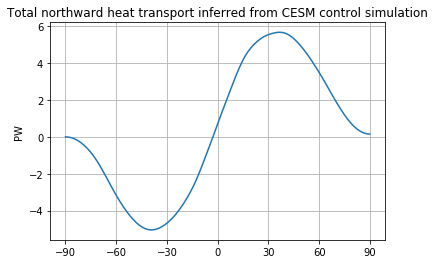

In [30]:
fig, ax = plt.subplots()
ax.plot(lat_cesm, inferred_heat_transport(ASR_cesm_zon - OLR_cesm_zon))
ax.set_ylabel('PW')
ax.set_xticks(ticks)
ax.grid()
ax.set_title('Total northward heat transport inferred from CESM control simulation')
fig

The total heat transport is very nearly symmetric about the equator, with poleward transport of about 5 to 6 PW in both hemispheres.

The transport peaks in magnitude near 35º latitude, the same latitude where we found that ASR = OLR. This is no coincidence!

Equatorward of 35º (across the tropics) there is **net heating by radiation** and **net cooling by dynamics**. The opposite is true poleward of 35º.

What about the "observations", i.e. the reanalysis data?

We can try to do the same calculation.

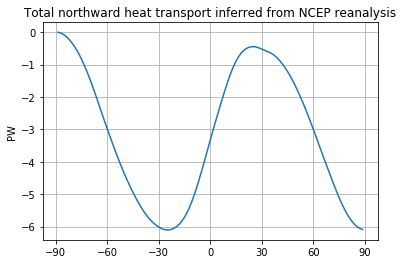

In [31]:
#  Need to flip the arrays because we want to start from the south pole
Rtoa_ncep = ASRzon-OLRzon
lat_ncep = ASRzon.lat
fig, ax = plt.subplots()
ax.plot(lat_ncep, inferred_heat_transport(Rtoa_ncep))
ax.set_ylabel('PW')
ax.set_xticks(ticks)
ax.grid()
ax.set_title('Total northward heat transport inferred from NCEP reanalysis')
fig

Our integral **does NOT go to zero at the North Pole!**. This means that the global energy budget is NOT balanced in the reanalysis data.

Let's look at the global imbalance:

In [32]:
#  global average of TOA radiation in reanalysis data
weight_ncep = cos(deg2rad(lat_ncep)) / cos(deg2rad(lat_ncep)).mean(dim='lat')
imbal_ncep = (Rtoa_ncep * weight_ncep).mean(dim='lat')
print( 'The net downward TOA radiation flux in NCEP renalysis data is %0.1f W/m2.' %imbal_ncep)

The net downward TOA radiation flux in NCEP renalysis data is -12.0 W/m2.


Evidently there is a substantial net flux out to space in this dataset.

Before we can compute heat transport from this data, we need to **balance the global data**.

To do this requires making assumptions about the spatial distribution of the imbalance. 

The simplest assumption we can make is that the imbalance is uniform across the Earth.

In [33]:
Rtoa_ncep_balanced = Rtoa_ncep - imbal_ncep
newimbalance = float((Rtoa_ncep_balanced * weight_ncep).mean(dim='lat'))
print( 'The net downward TOA radiation flux after balancing the data is %0.2e W/m2.' %newimbalance)

The net downward TOA radiation flux after balancing the data is 3.45e-15 W/m2.


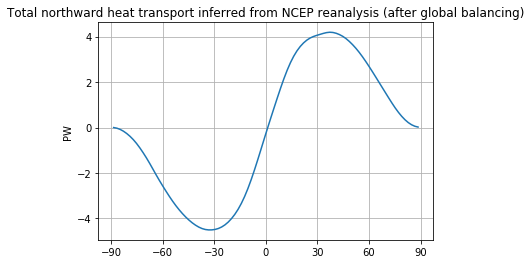

In [34]:
fig, ax = plt.subplots()
ax.plot(lat_ncep, inferred_heat_transport(Rtoa_ncep_balanced))
ax.set_ylabel('PW')
ax.set_xticks(ticks)
ax.grid()
ax.set_title('Total northward heat transport inferred from NCEP reanalysis (after global balancing)')
fig

We now get a physically sensible result (zero at both poles).

The heat transport is poleward everywhere, and very nearly anti-symmetric across the equator. The shape is very similar to what we found from the CESM simulation, with peaks near 35º.

However the magnitude of the peaks is substantially smaller. **Does this indicate a shortcoming of the CESM simulation?**

**Probably not!**

It turns out that our result here is **very sensitive to the details** of how we balance the radiation data.

As an exercise, you might try applying different corrections other than the globally uniform correction we used above. E.g. try weighting the tropics or the mid-latitudes more strongly.

### An example of a recently published observational estimate of meridional heat transport

<img src='../images/Fasullo_Trenberth_2008b_Fig7.jpg'>

> The ERBE period zonal mean annual cycle of the meridional energy transport in PW by (a) the atmosphere and ocean as inferred from ERBE $R_T$, NRA $\delta$A_E/$\delta$t, and GODAS $\delta$O_E/$\delta$t; (b) the atmosphere based on NRA; and (c) by the ocean as implied by ERBE + NRA $F_S$ and GODAS $\delta$O_E/$\delta$t. Stippling and hatching in (a)–(c) represent regions and times of year in which the standard deviation of the monthly mean values among estimates, some of which include the CERES period (see text), exceeds 0.5 and 1.0 PW, respectively. (d) The median annual mean transport by latitude for the total (gray), atmosphere (red), and ocean (blue) accompanied with the associated $\pm2\sigma$ range (shaded).

This is a reproduction of Figure 7 from Fasullo and Trenberth (2008), "The Annual Cycle of the Energy Budget. Part II: Meridional Structures and Poleward Transports", J. Climate 21, doi:10.1175/2007JCLI1936.1

This figure shows the breakdown of the heat transport by **season** as well as the **partition between the atmosphere and ocean**.

Focussing just on the total, annual transport in panel (d) (black curve), we see that is quite consistent with what we computed from the CESM simulation.

____________
<a id='section6'></a>

## 6. Energy budgets for the atmosphere and ocean
____________

The total transport (which we have been inferring from the TOA radiation imbalance) includes contributions from both the **atmosphere** and the **ocean**:

$$ \mathcal{H} = \mathcal{H}_{a} + \mathcal{H}_{o} $$

We have used the **TOA imbalance** to infer the total transport because TOA radiation is the only significant energy source / sink to the climate system as a whole.

However, if we want to study (or model) the individual contributions from the atmosphere and ocean, we need to consider the energy budgets for **each individual domain**.

We will therefore need to broaden our discussion to include the **net surface heat flux**, i.e. the total flux of energy between the surface and the atmosphere.

### Surface fluxes

Let's denote the **net upward energy flux at the surface** as $F_S$.

There are four principal contributions to $F_S$:

1. Shortwave radiation
2. Longwave radiation
3. Sensible heat flux
4. Evaporation or latent heat flux

Sensible and latent heat fluxes involve turbulent exchanges in the planetary boundary layer. We will look at these in more detail later.

In [35]:
# monthly climatologies for surface flux data from reanalysis
#  all defined as positive UP
#ncep_nswrs = xr.open_dataset(ncep_url + "surface_gauss/nswrs.sfc.mon.1981-2010.ltm.nc", decode_times=False)
#ncep_nlwrs = xr.open_dataset(ncep_url + "surface_gauss/nlwrs.sfc.mon.1981-2010.ltm.nc", decode_times=False)
#ncep_shtfl = xr.open_dataset(ncep_url + "surface_gauss/shtfl.sfc.mon.1981-2010.ltm.nc", decode_times=False)
#ncep_lhtfl = xr.open_dataset(ncep_url + "surface_gauss/lhtfl.sfc.mon.1981-2010.ltm.nc", decode_times=False)
ncep_nswrs = xr.open_dataset(url + 'surface_gauss/nswrs')
ncep_nlwrs = xr.open_dataset(url + 'surface_gauss/nlwrs')
ncep_shtfl = xr.open_dataset(url + 'surface_gauss/shtfl')
ncep_lhtfl = xr.open_dataset(url + 'surface_gauss/lhtfl')

In [36]:
#  Calculate ANNUAL AVERAGE net upward surface flux
ncep_net_surface_up = (ncep_nlwrs.nlwrs
                     + ncep_nswrs.nswrs
                     + ncep_shtfl.shtfl
                     + ncep_lhtfl.lhtfl
                      ).mean(dim='time')

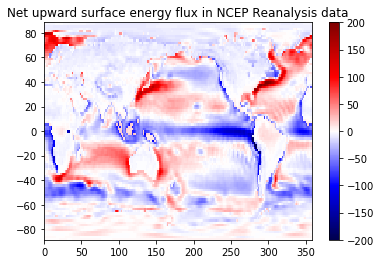

In [37]:
lon_ncep = ncep_net_surface_up.lon
fig, ax = plt.subplots()
cax = ax.pcolormesh(lon_ncep, lat_ncep, ncep_net_surface_up, 
               cmap=plt.cm.seismic, vmin=-200., vmax=200. )
fig.colorbar(cax, ax=ax)
ax.set_title('Net upward surface energy flux in NCEP Reanalysis data')
fig

Discuss...  Large net fluxes over ocean, not over land.

### Energy budget for the ocean

Using exactly the same reasoning we used for the whole climate system, we can write a budget for the OCEAN ONLY:

$$ \frac{\partial E_o}{\partial t} = -F_S - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H_o}}{\partial \phi} $$

In principle it is possible to calculate $\mathcal{H}_o$ from this budget, analagously to how we calculated the total $\mathcal{H}$.

Assuming that

- surface fluxes are well-known
- the ocean heat storage is negligible (a big assumption!)

we can write

$$ \mathcal{H}_o(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} - \cos⁡\phi^\prime ~ F_S d\phi^\prime  $$

where the minus sign account for the fact that we defined $F_S$ as **positive up** (out of the ocean).

### Energy budget for the atmosphere

The net energy source to the atmosphere is the sum of the TOA flux and the surface flux. Thus we can write

$$ \frac{\partial E_a}{\partial t} = R_{TOA} + F_S - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H_a}}{\partial \phi} $$

and we can similarly integrate to get the transport:

$$ \mathcal{H}_a(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ \big( R_{TOA} + F_S \big) d\phi^\prime  $$

Note that these formulas ensure that $\mathcal{H} = \mathcal{H}_a + \mathcal{H}_o$.

### Atmospheric water budget and latent heat transport

Water vapor contributes to the atmopsheric energy transport because **energy consumed through evaporation** is converted back to **sensible heat** wherever the vapor subsequently condenses. 

If the evaporation and the condensation occur at different latitudes then there is a net transport of energy due to the **movement of water vapor**.

We can use the same kind of budget reasoning to compute this **latent heat transport**. But this time we will make a budget for water vapor only.

The only sources and sinks of water vapor to the atmosphere are surface evaporation and precipitation:

$$ L_v \frac{\partial Q}{\partial t} = L_v \big( Evap - Precip \big) - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H}_{LH}}{\partial \phi} $$

Here we are using

- $Q$ is the depth-integrated water vapor (the "precipitable water") in kg m$^{-2}$
- Evap and Precip are in kg m$^{-2}$ s$^{-1}$ (equivalent to mm/s)
- $L_v = 2.5 \times 10^6$ J kg$^{-1}$ is the latent heat of vaporization
- $\mathcal{H}_{LH}$ is the northward latent heat transport

All terms in the above equation thus have units of W m$^{-2}$.

Using the now-familiar equilibrium reasoning, we can use this water balance to compute the latent heat transport from the net surface evaporation minus precipitation:

$$ \mathcal{H}_{LH}(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ L_v ~\big( Evap - Precip \big) d\phi^\prime  $$

From this we can then infer all the energy transport associated with the motion of dry air as a residual:

$$\mathcal{H}_{Dry} = \mathcal{H}_a - \mathcal{H}_{LH} $$

____________
<a id='section7'></a>

## 7. Calculating the partitioning of poleward energy transport into different components
____________



This function implements the above formulas to calculate the following quantities from CESM simulation output:

- Total heat transport, $\mathcal{H}$
- Ocean heat transport, $\mathcal{H}_o$
- Atmospheric heat transport, $\mathcal{H}_a$
- Atmospheric latent heat transport, $\mathcal{H}_{LH}$
- Atmospheric dry heat transport, $\mathcal{H}_{Dry}$

In [38]:
def CESM_heat_transport(run):
    #  Take zonal averages of the necessary input fields
    fieldlist = ['FLNT','FSNT','LHFLX','SHFLX','FLNS','FSNS','PRECSC','PRECSL','QFLX','PRECC','PRECL']
    zon = run[fieldlist].mean(dim='lon')
    OLR = zon.FLNT
    ASR = zon.FSNT
    Rtoa = ASR - OLR  # net downwelling radiation
    #  surface energy budget terms, all defined as POSITIVE UP
    #    (from ocean to atmosphere)
    LHF = zon.LHFLX
    SHF = zon.SHFLX
    LWsfc = zon.FLNS
    SWsfc = -zon.FSNS
    SnowFlux =  ((zon.PRECSC + zon.PRECSL) *
                      const.rho_w * const.Lhfus)
    # net upward radiation from surface
    SurfaceRadiation = LWsfc + SWsfc
    # net upward surface heat flux
    SurfaceHeatFlux = SurfaceRadiation + LHF + SHF + SnowFlux
    # net heat flux into atmosphere
    Fatmin = Rtoa + SurfaceHeatFlux
    #  hydrological cycle, all terms in  kg/m2/s or mm/s
    Evap = zon.QFLX
    Precip = (zon.PRECC + zon.PRECL) * const.rho_w
    EminusP = Evap - Precip
        
    # heat transport terms
    HTmonthly = {}
    HTmonthly['total'] = inferred_heat_transport(Rtoa)
    HTmonthly['atm'] = inferred_heat_transport(Fatmin)
    HTmonthly['ocean'] = inferred_heat_transport(-SurfaceHeatFlux)
    HTmonthly['latent'] = inferred_heat_transport(EminusP*const.Lhvap) # atm. latent heat transport from moisture imbal.
    HTmonthly['dse'] = HTmonthly['atm'] - HTmonthly['latent']  # dry static energy transport as residual

    #  annual averages
    HTann = {}
    for name, value in HTmonthly.items():
        HTann[name] = value.mean(dim='time')
        
    return HTann, HTmonthly

In [39]:
#  Compute heat transport partition for both control and 2xCO2 simulations
HT_control, _ = CESM_heat_transport(atm_control)
HT_2xCO2, _ = CESM_heat_transport(atm_2xCO2)

In [40]:
fig = plt.figure(figsize=(16,6))
runs = [HT_control, HT_2xCO2]
N = len(runs)

for n, HT in enumerate([HT_control, HT_2xCO2]):
    ax = fig.add_subplot(1, N, n+1)
    ax.plot(lat_cesm, HT['total'], 'k-', label='total', linewidth=2)
    ax.plot(lat_cesm, HT['atm'], 'r-', label='atm', linewidth=2)
    ax.plot(lat_cesm, HT['dse'], 'r--', label='dry')
    ax.plot(lat_cesm, HT['latent'], 'r:', label='latent')
    ax.plot(lat_cesm, HT['ocean'], 'b-', label='ocean', linewidth=2)

    ax.set_xlim(-90,90)
    ax.set_xticks(ticks)
    ax.legend(loc='upper left')
    ax.grid()

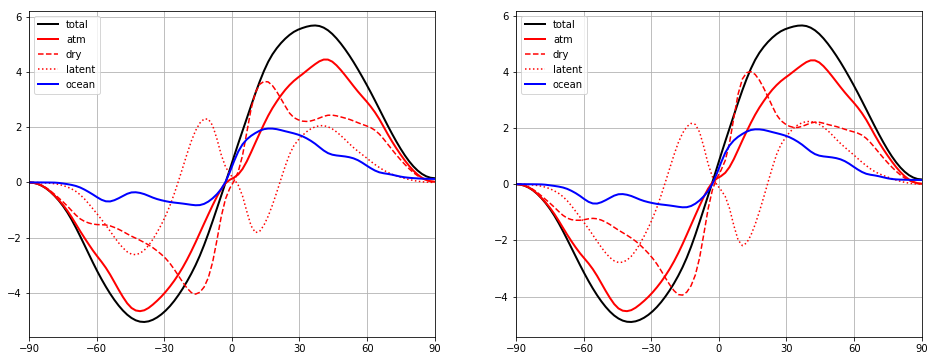

In [41]:
fig

Discuss the shape of these curves.

Actually very very similar before and after the global warming.

____________
<a id='section8'></a>

## 8. Mechanisms of heat transport
____________



Energy is transported across latitude lines whenever there is an exchange of fluids with different energy content: e.g. warm fluid moving northward while colder fluid moves southward.

Thus energy transport always involves **correlations between northward component of velocity $v$ and energy $e$**

The transport is an integral of these correlations, around a latitude circle and over the depth of the fluid:

$$ \mathcal{H} = \int_0^{2\pi} \int_{\text{bottom}}^{\text{top}} \rho ~ v ~ e ~ dz ~ a \cos\phi ~ d\lambda$$

The total transport (which we have been inferring from the TOA radiation imbalance) includes contributions from both the **atmosphere** and the **ocean**:

$$ \mathcal{H} = \mathcal{H}_{a} + \mathcal{H}_{o} $$

We can apply the above definition to both fluids (with appropriate values for bottom and top in the depth integral).

The appropriate measure of energy content is different for the atmosphere and ocean.

For the ocean, we usually use the **enthalpy for an incompressible fluid**:

$$ e_o \approx c_w ~ T $$

where $c_w \approx 4.2 \times 10^{3}$ J kg$^{-1}$ K$^{-1}$ is the specific heat for seawater.

For the atmosphere, it's a bit more complicated. We need to account for both the compressibility of air, and for its water vapor content. This is because of the latent energy associated with evaporation and condensation of vapor.

It is convenient to define the **moist static energy** for the atmosphere:

$$ MSE = c_p ~T + g~ Z + L_v ~q  $$

whose terms are respectively the internal energy, the potential energy, and the latent heat of water vapor (see texts on atmopsheric thermodynamics for details).

We will assume that $MSE$ is a good approximation to the total energy content of the atmosphere, so

$$ e_a \approx MSE $$

Note that in both cases we have **neglected the kinetic energy** from this budget.

The kinetic energy per unit mass is $e_k = |\vec{v}|^2/2$, where $\vec{v} = (u,v,w)$ is the velocity vector.

In practice it is a very small component of the total energy content of the fluid and is usually neglected in analyses of poleward energy transport.

As we have seen, we can further divide the atmospheric transport into transports due to the movement of **dry air** (the tranport of **dry static energy**) and transport associated with evaporation and condensation of **water vapor** (the **latent heat transport**)

### Mechanisms of energy transport in the ocean

Assuming the ocean extends from $z=-H$ to $z=0$ we can then write

$$ \mathcal{H}_o \approx a \cos\phi \int_0^{2\pi} \int_{-H}^{0}  c_w ~\rho ~ v ~ T ~ dz  ~ d\lambda$$

setting $v ~ T = 0$ at all land locations around the latitude circle.

The northward transport $\mathcal{H}_o$ is positive if there is a net northward flow of warm water and southward flow of cold water.

This can occur due to **horizontal** differences in currents and temperatures.

The classic example is flow in the subtropical gyres and western boundary currents. In the subtropical North Atlantic, there is rapid northward flow of warm water in the Gulf Stream. This is compensated by a slow southward flow of cooler water across the interior of the basin. 

**Because the water masses are at different temperatures, equal and opposite north-south exchanges of mass result in net northward transport of energy.**

Energy transport can also result from **vertical** structure of the currents.

There is a large-scale **overturning circulation** in the Atlantic that involves near-surface northward flow of warmer water, compensated by deeper southward flow of colder water.

Again, equal exchange of water but net transport of energy.

### *These notes are not really finished...*

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Version information
____________


In [42]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, xarray, climlab

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.1.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.14.2
scipy 1.0.0
matplotlib 2.0.2
xarray 0.11.2
climlab 0.7.1.dev5
Tue Jan 15 14:19:57 2019 EST

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________